# Phase 1: Embedding Analysis

This notebook analyzes the LLM embeddings generated from scene classification metadata.

**Input Data:**
- 26 scenes with 19 key-value attributes each
- Embedding dimension: 4096

**Visualizations:**
1. PCA of all embeddings colored by key
2. t-SNE of all embeddings colored by key
3. Per-key PCA distributions (weather, road_type, safety_criticality)
4. Cosine similarity heatmap between keys

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

# Configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

# Paths
DATA_DIR = Path('/Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120')
FIGURE_DIR = DATA_DIR / 'figures'
FIGURE_DIR.mkdir(exist_ok=True)

## Load Data

In [18]:
# Load embeddings
data = np.load(DATA_DIR / 'embeddings.npz')
clip_ids = data['clip_ids']
keys = data['keys']
embeddings = data['embeddings']

print(f'Scenes: {len(clip_ids)}')
print(f'Keys: {len(keys)}')
print(f'Embedding shape: {embeddings.shape}')
print(f'Keys: {list(keys)}')

Scenes: 26
Keys: 19
Embedding shape: (26, 19, 4096)
Keys: [np.str_('weather'), np.str_('time_of_day'), np.str_('road_type'), np.str_('traffic_situation'), np.str_('pedestrians_present'), np.str_('cyclists_present'), np.str_('construction_activity'), np.str_('traffic_signals_visible'), np.str_('vehicle_count'), np.str_('occlusion_level'), np.str_('depth_complexity'), np.str_('nearest_vehicle_distance'), np.str_('visual_degradation'), np.str_('similar_object_confusion'), np.str_('safety_criticality'), np.str_('vulnerable_road_users'), np.str_('required_action'), np.str_('pedestrian_count'), np.str_('vehicle_count_by_type')]


In [19]:
# Load text metadata
with open(DATA_DIR / 'embedding_texts.json', 'r') as f:
    text_data = json.load(f)

texts = text_data['texts']
print(f'Sample texts for first scene:')
for t in texts[0][:5]:
    print(f'  {t}')

Sample texts for first scene:
  weather: foggy
  time of day: night
  road type: highway
  traffic situation: complex
  pedestrians present: false


## 1. PCA of All Embeddings (Colored by Key)

Flatten all embeddings to visualize the distribution of 494 points (26 scenes x 19 keys) in 2D.

In [20]:
# Reshape embeddings: (26, 19, 4096) -> (494, 4096)
n_scenes, n_keys, emb_dim = embeddings.shape
flat_embeddings = embeddings.reshape(-1, emb_dim)

# Create labels for each point
key_labels = np.tile(keys, n_scenes)
scene_labels = np.repeat(np.arange(n_scenes), n_keys)

print(f'Flattened shape: {flat_embeddings.shape}')
print(f'Key labels: {len(key_labels)}')

Flattened shape: (494, 4096)
Key labels: 494


In [21]:
# PCA
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(flat_embeddings)

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Total explained: {sum(pca.explained_variance_ratio_):.2%}')

Explained variance ratio: [0.14726463 0.08858919]
Total explained: 23.59%


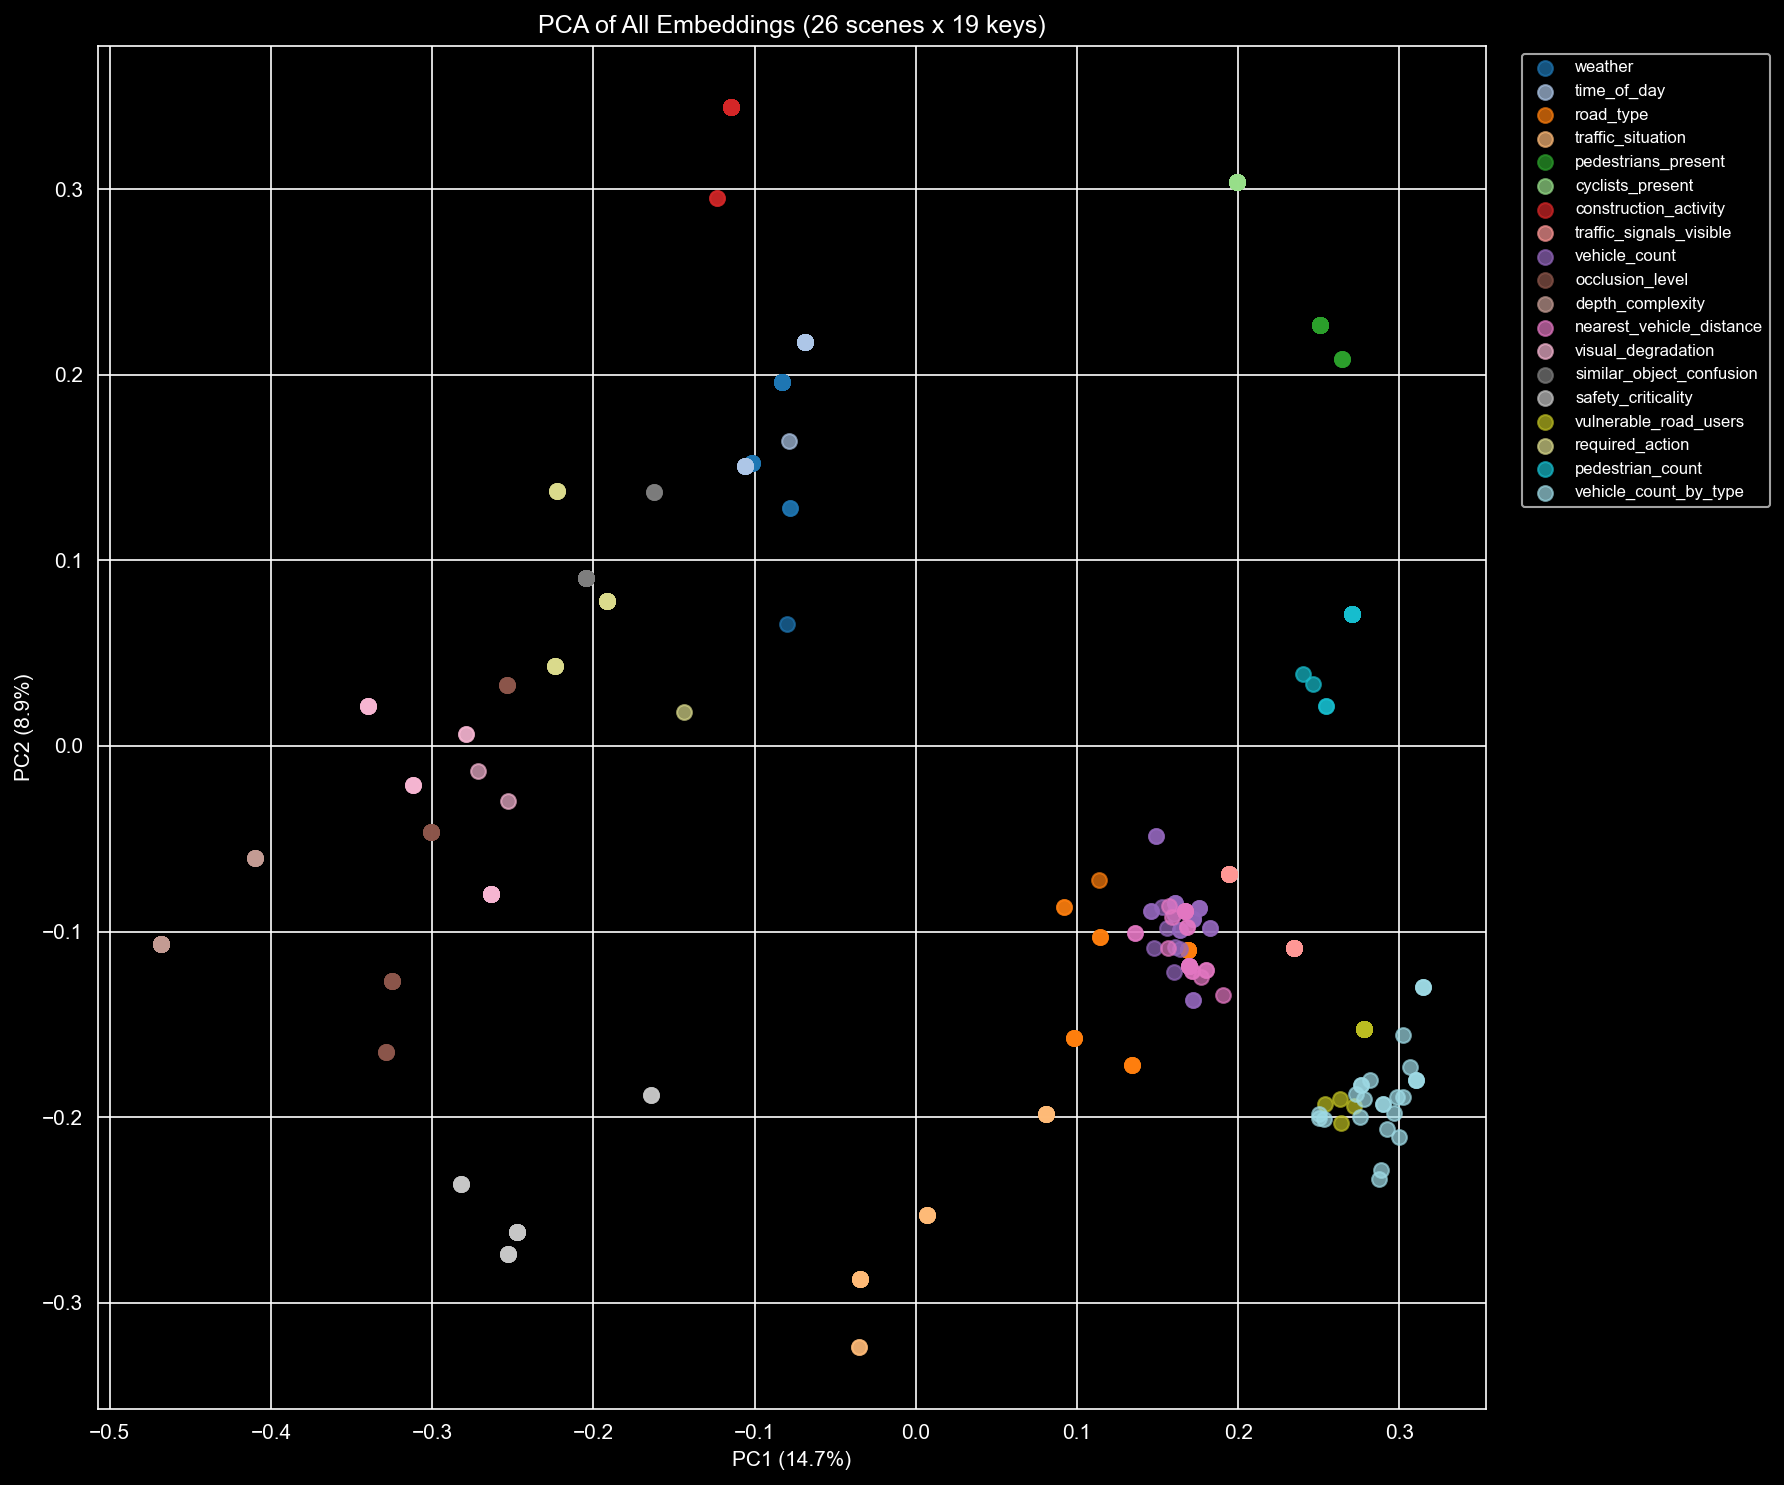

In [22]:
# Create color mapping for keys
unique_keys = list(keys)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_keys)))
key_to_color = {k: colors[i] for i, k in enumerate(unique_keys)}
point_colors = [key_to_color[k] for k in key_labels]

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

for key in unique_keys:
    mask = key_labels == key
    ax.scatter(pca_coords[mask, 0], pca_coords[mask, 1], 
               c=[key_to_color[key]], label=key, alpha=0.7, s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA of All Embeddings (26 scenes x 19 keys)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()

fig.savefig(FIGURE_DIR / '01_pca_by_key.png', bbox_inches='tight')
plt.show()

## 2. t-SNE of All Embeddings (Colored by Key)

t-SNE provides a non-linear projection that may reveal clusters not visible in PCA.

In [23]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_coords = tsne.fit_transform(flat_embeddings)

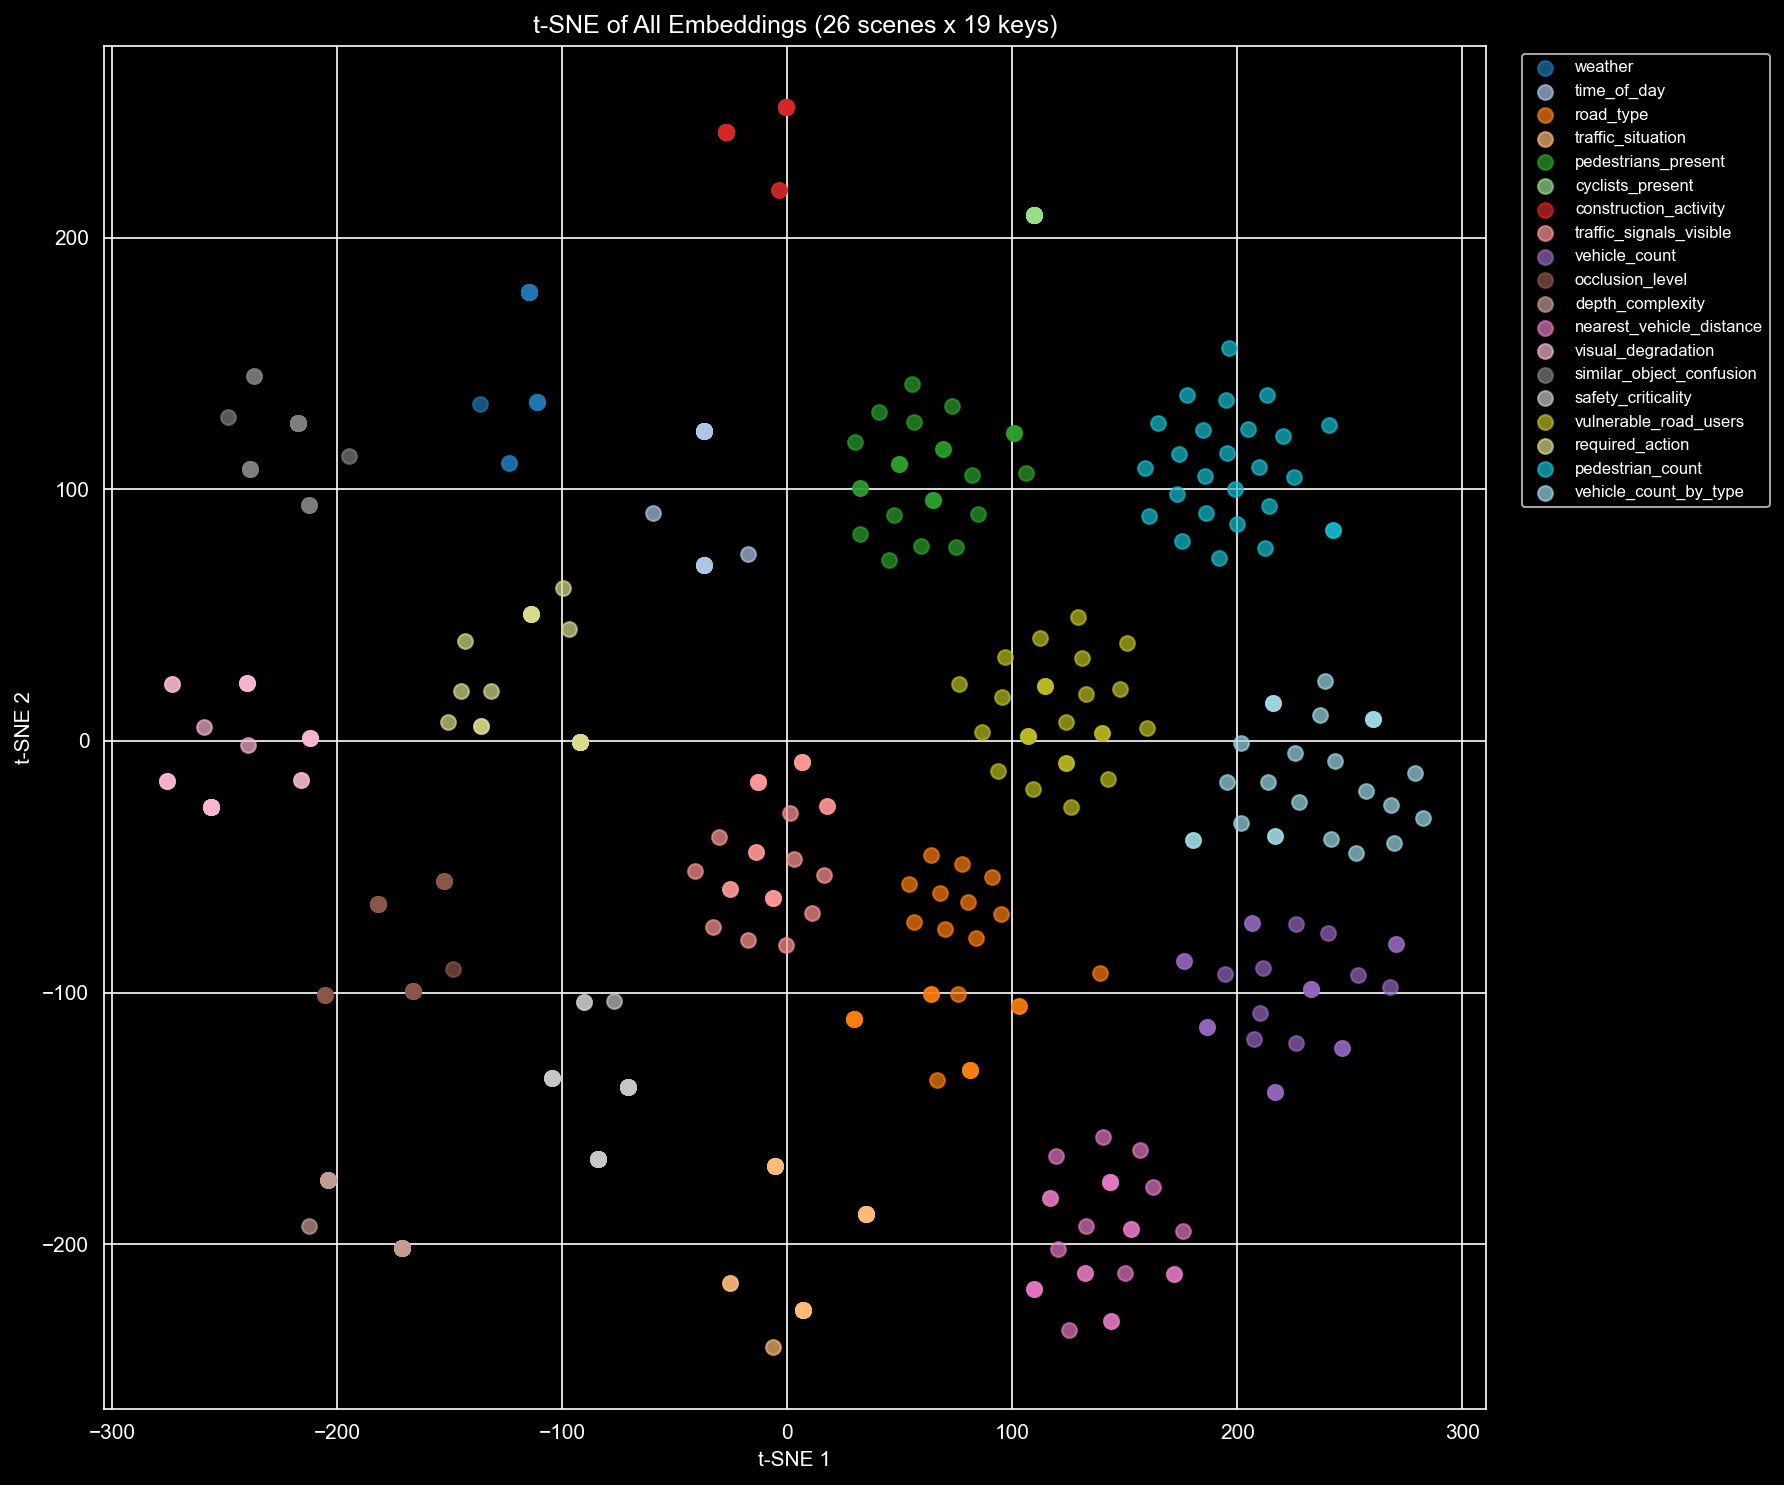

In [24]:
# Plot
fig, ax = plt.subplots(figsize=(12, 10))

for key in unique_keys:
    mask = key_labels == key
    ax.scatter(tsne_coords[mask, 0], tsne_coords[mask, 1], 
               c=[key_to_color[key]], label=key, alpha=0.7, s=50)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE of All Embeddings (26 scenes x 19 keys)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()

fig.savefig(FIGURE_DIR / '01_tsne_by_key.png', bbox_inches='tight')
plt.show()

## 3. Per-Key Embedding Distributions

Analyze how embeddings for specific keys distribute based on their values.

In [25]:
def extract_values_for_key(texts, key_name):
    """Extract values for a specific key from all scenes."""
    values = []
    key_idx = list(keys).index(key_name)
    for scene_texts in texts:
        text = scene_texts[key_idx]
        # Extract value after colon
        value = text.split(': ', 1)[1] if ': ' in text else text
        values.append(value)
    return values

def plot_pca_for_key(key_name, save_name):
    """Create PCA plot for a specific key, colored by value."""
    key_idx = list(keys).index(key_name)
    key_embeddings = embeddings[:, key_idx, :]  # (26, 4096)
    values = extract_values_for_key(texts, key_name)
    
    # PCA
    pca_key = PCA(n_components=2, random_state=42)
    coords = pca_key.fit_transform(key_embeddings)
    
    # Get unique values and colors
    unique_values = list(set(values))
    n_colors = max(len(unique_values), 3)
    colors = plt.cm.Set2(np.linspace(0, 1, n_colors))
    value_to_color = {v: colors[i] for i, v in enumerate(unique_values)}
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for val in unique_values:
        mask = np.array(values) == val
        ax.scatter(coords[mask, 0], coords[mask, 1],
                   c=[value_to_color[val]], label=val, s=100, alpha=0.8)
    
    ax.set_xlabel(f'PC1 ({pca_key.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca_key.explained_variance_ratio_[1]:.1%})')
    ax.set_title(f'PCA of "{key_name}" Embeddings (n={len(values)})')
    ax.legend(title='Value', loc='best')
    plt.tight_layout()
    
    fig.savefig(FIGURE_DIR / save_name, bbox_inches='tight')
    plt.show()
    
    return unique_values

### 3.1 Weather

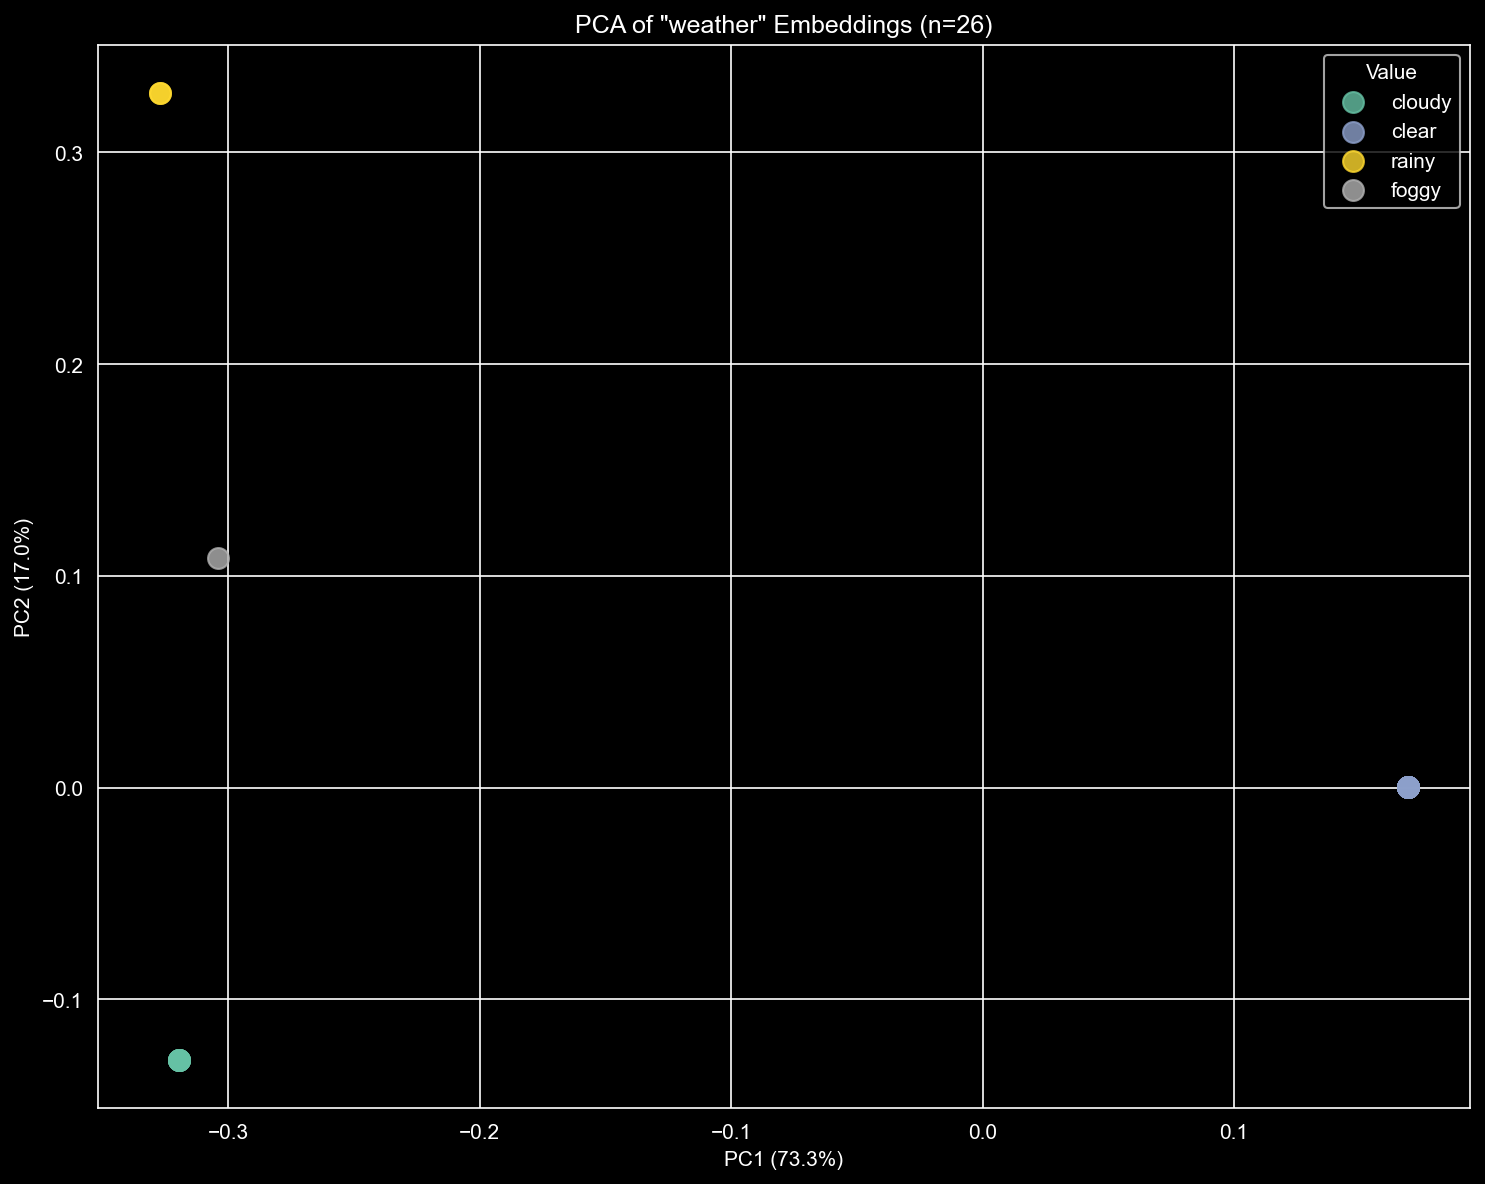

Weather values: ['cloudy', 'clear', 'rainy', 'foggy']


In [26]:
weather_values = plot_pca_for_key('weather', '01_pca_weather.png')
print(f'Weather values: {weather_values}')

### 3.2 Road Type

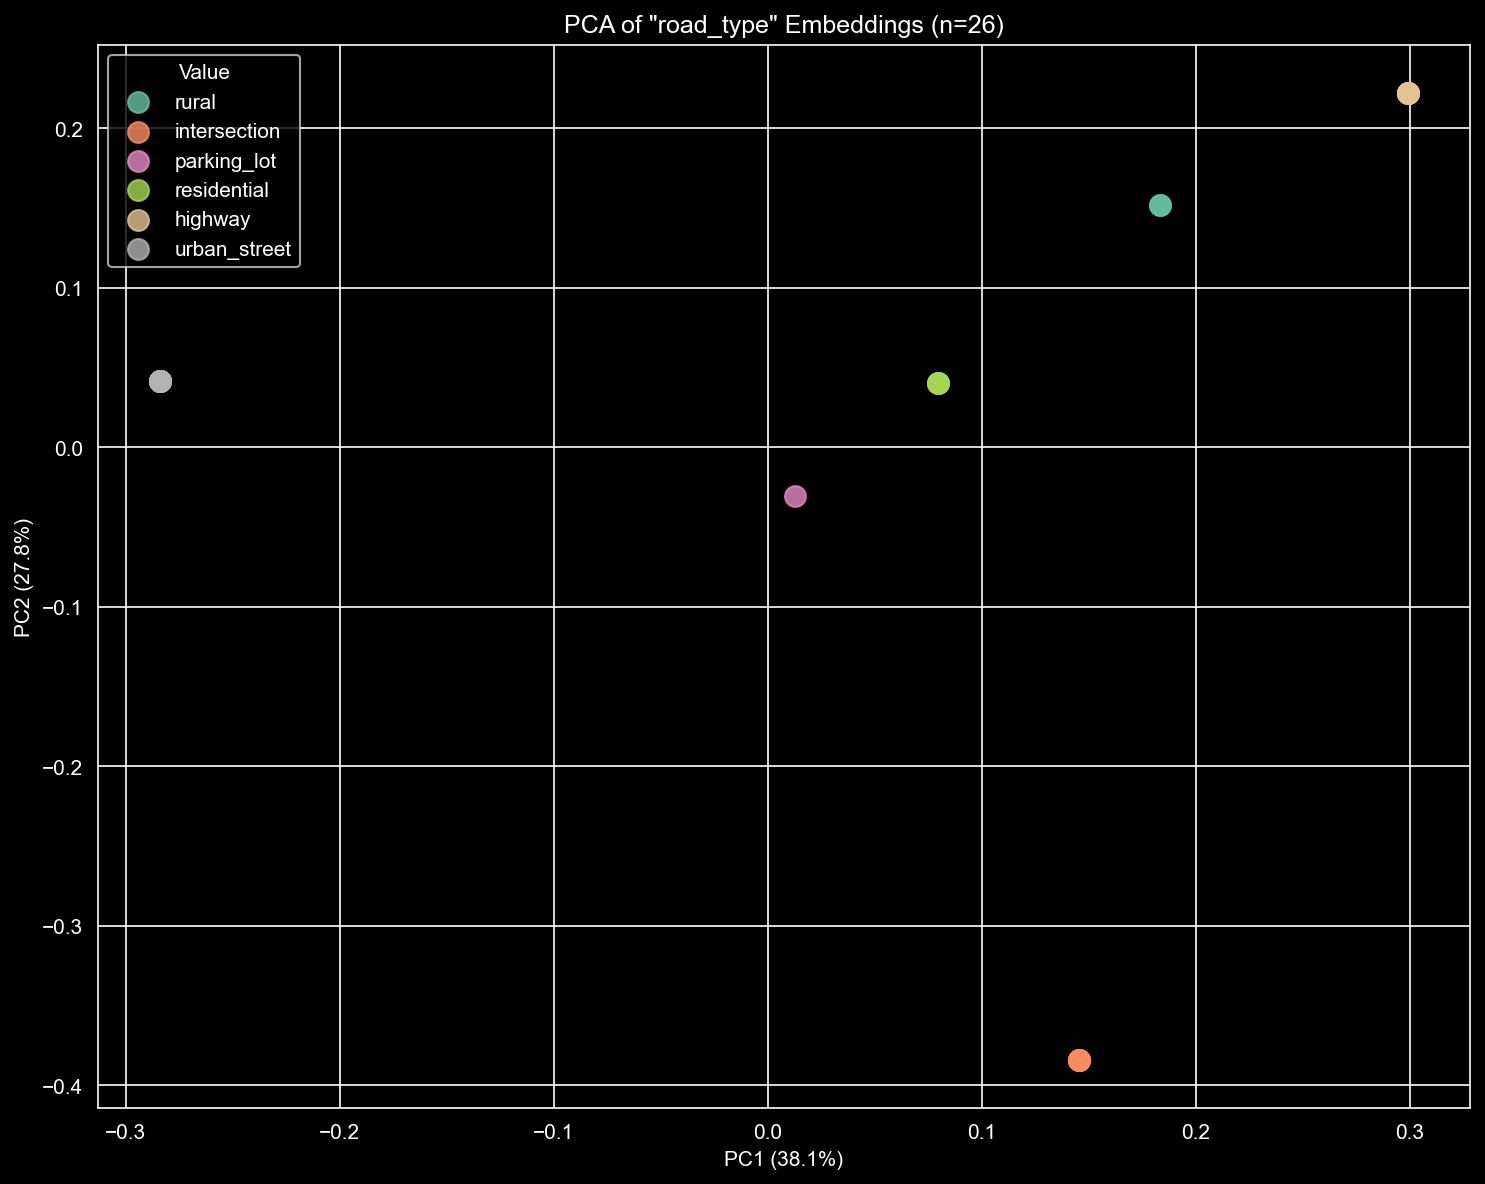

Road type values: ['rural', 'intersection', 'parking_lot', 'residential', 'highway', 'urban_street']


In [27]:
road_values = plot_pca_for_key('road_type', '01_pca_road_type.png')
print(f'Road type values: {road_values}')

### 3.3 Safety Criticality

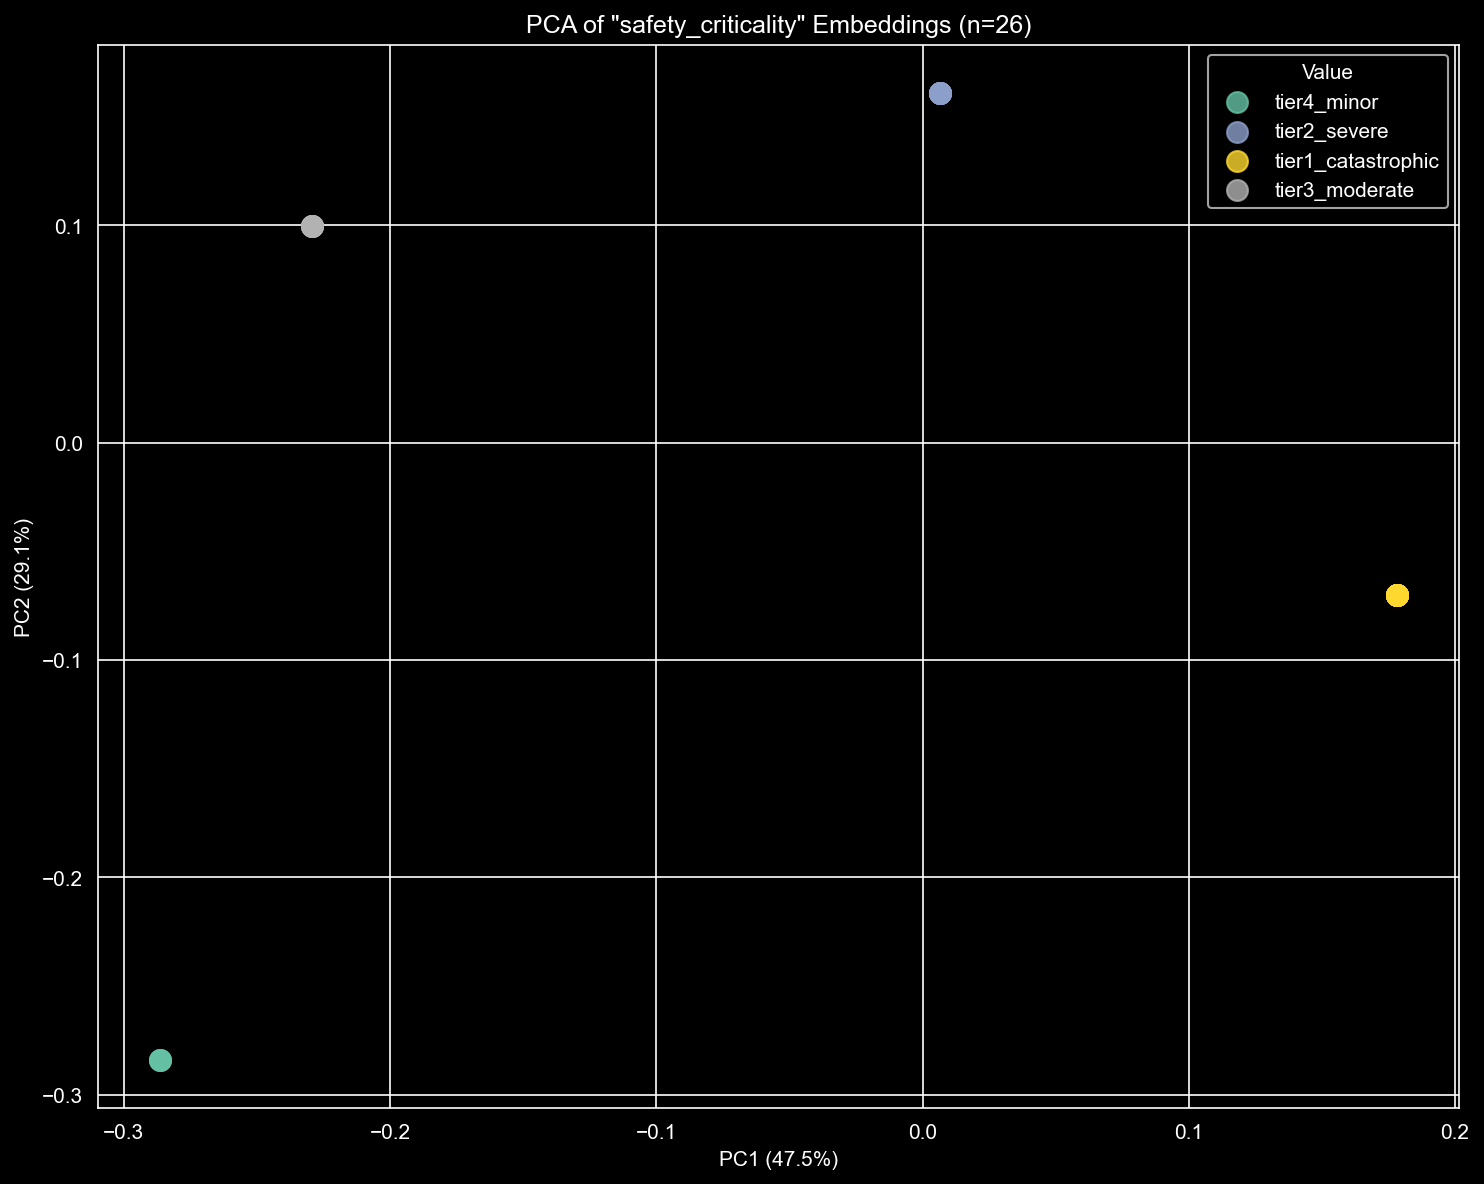

Safety criticality values: ['tier4_minor', 'tier2_severe', 'tier1_catastrophic', 'tier3_moderate']


In [28]:
safety_values = plot_pca_for_key('safety_criticality', '01_pca_safety.png')
print(f'Safety criticality values: {safety_values}')

## 4. Cosine Similarity Heatmap Between Keys

Compute average cosine similarity between embeddings of different keys across all scenes.

In [29]:
# Compute mean embedding per key (average across all scenes)
mean_key_embeddings = embeddings.mean(axis=0)  # (19, 4096)
print(f'Mean key embeddings shape: {mean_key_embeddings.shape}')

Mean key embeddings shape: (19, 4096)


In [30]:
# Compute cosine similarity matrix
sim_matrix = cosine_similarity(mean_key_embeddings)  # (19, 19)
print(f'Similarity matrix shape: {sim_matrix.shape}')
print(f'Similarity range: [{sim_matrix.min():.3f}, {sim_matrix.max():.3f}]')

Similarity matrix shape: (19, 19)
Similarity range: [0.526, 1.000]


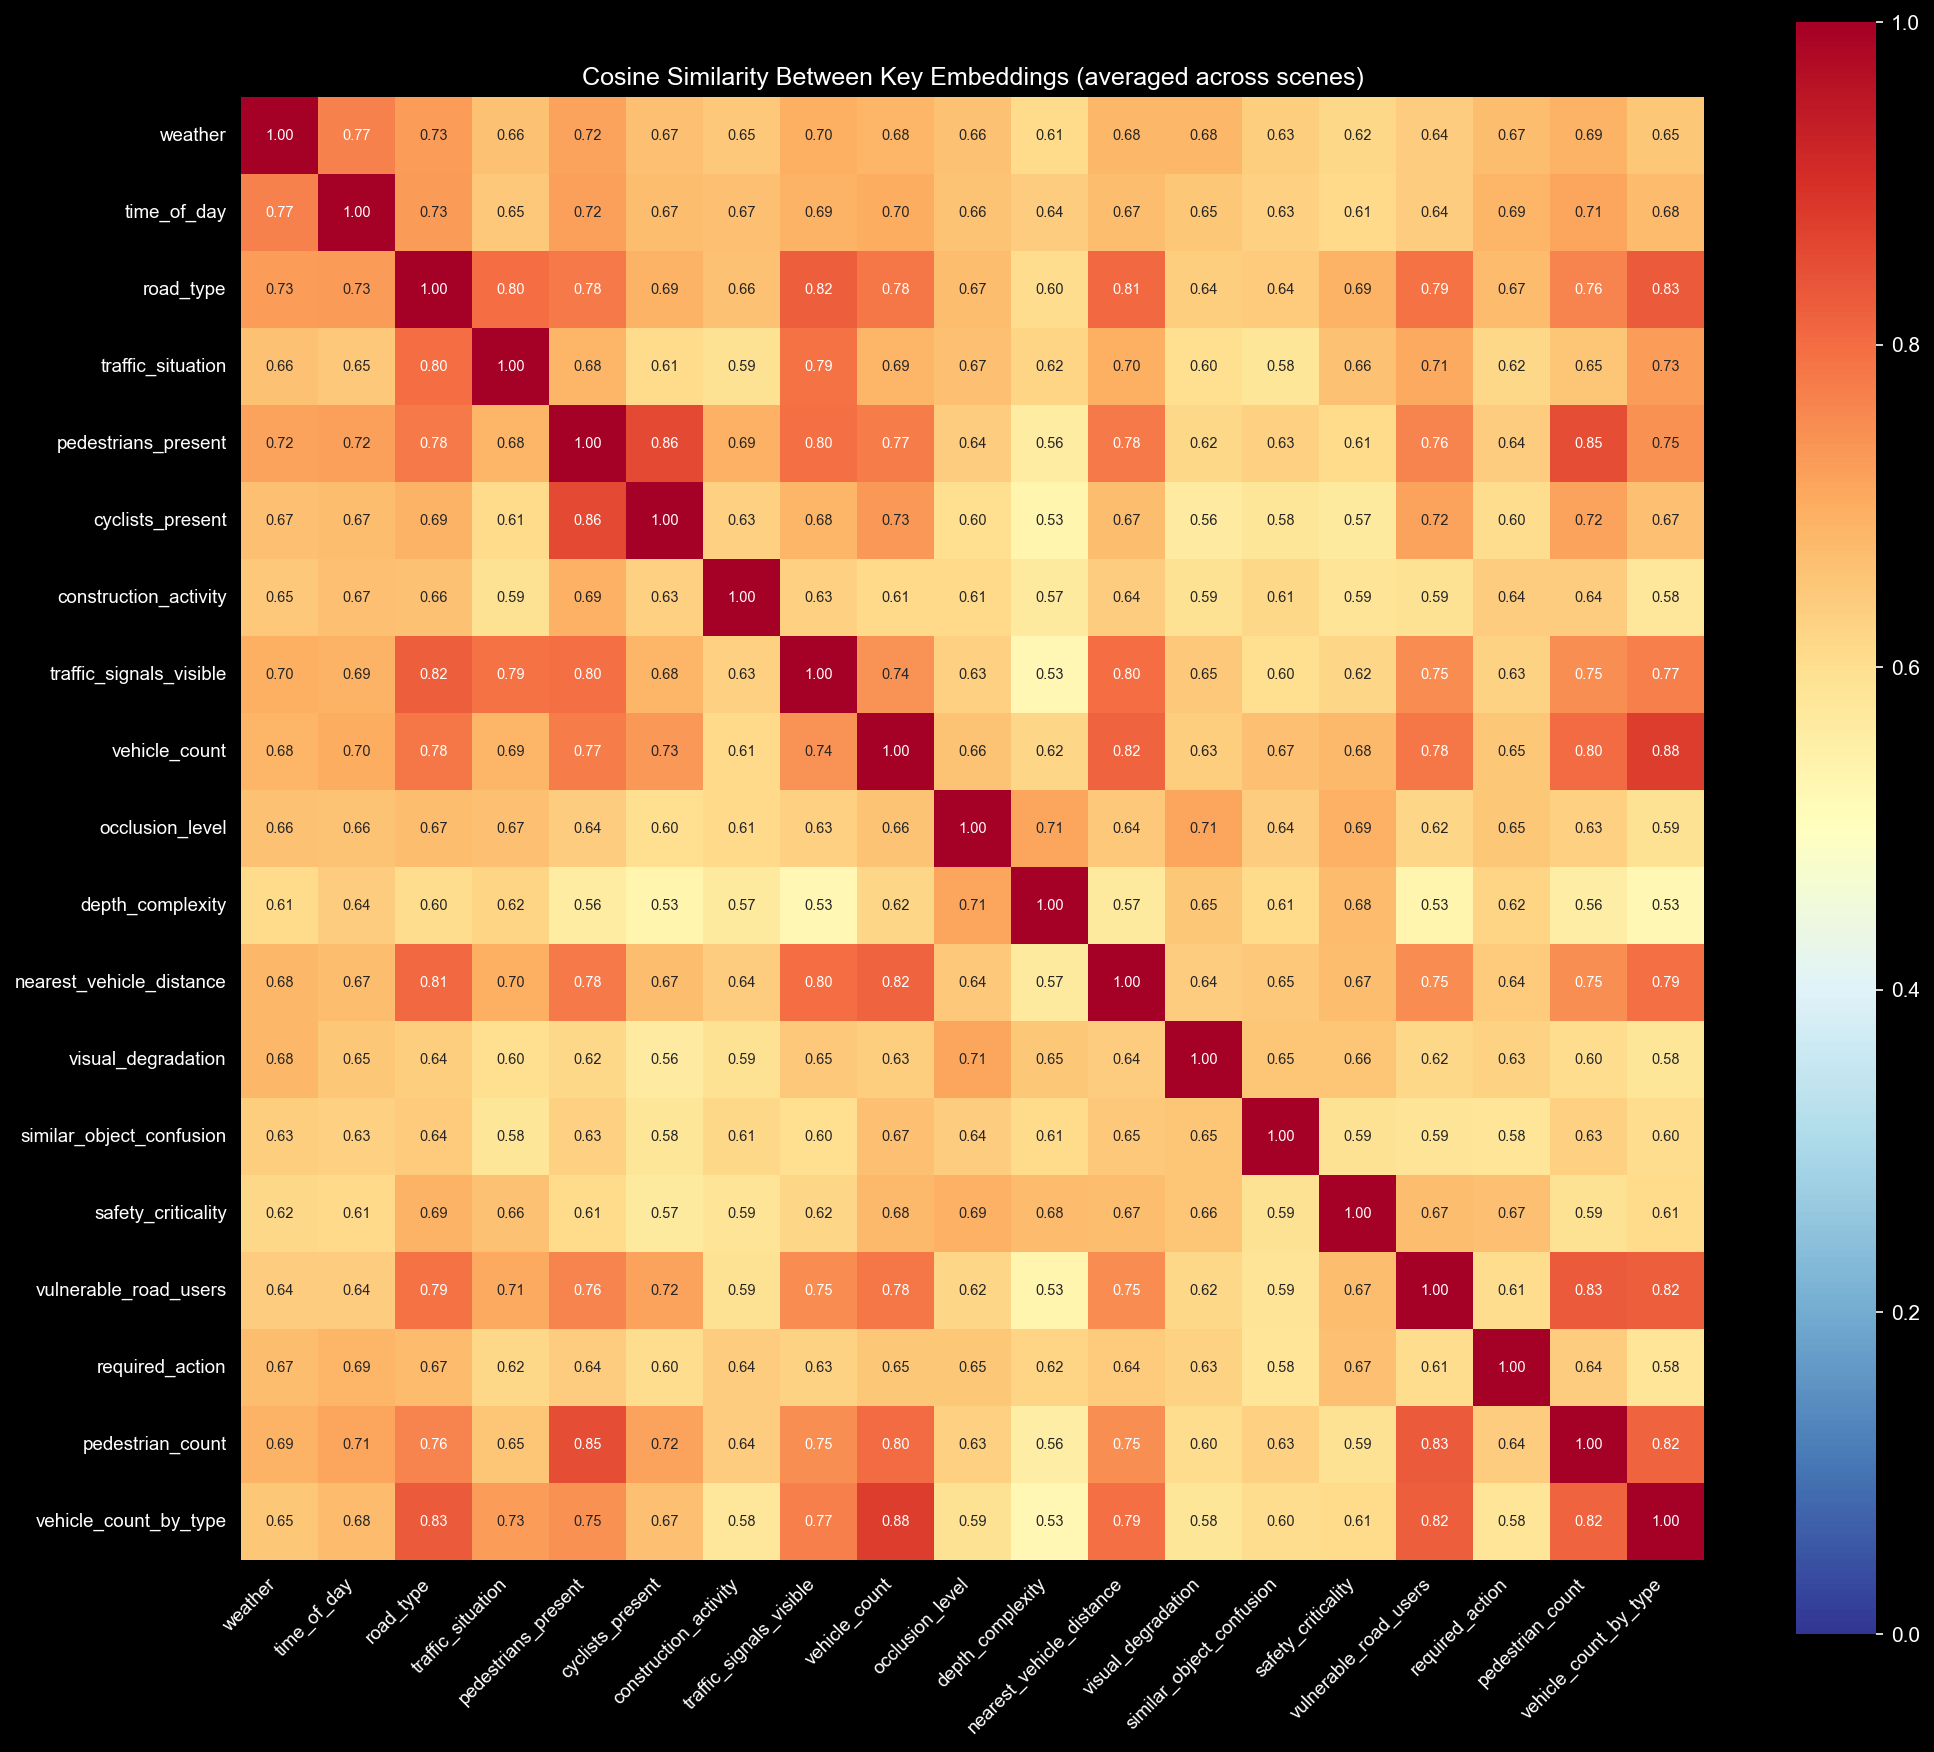

In [31]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(sim_matrix, 
            xticklabels=keys, 
            yticklabels=keys,
            annot=True, 
            fmt='.2f',
            cmap='RdYlBu_r',
            center=0.5,
            vmin=0, vmax=1,
            square=True,
            ax=ax,
            annot_kws={'size': 7})

ax.set_title('Cosine Similarity Between Key Embeddings (averaged across scenes)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
plt.tight_layout()

fig.savefig(FIGURE_DIR / '01_key_similarity.png', bbox_inches='tight')
plt.show()

## Summary

The visualizations reveal:

1. **PCA/t-SNE by Key**: Shows how different attribute types cluster in embedding space
2. **Per-Key Distributions**: Reveals whether attribute values (e.g., foggy vs clear) are separable
3. **Key Similarity**: Identifies which attributes have semantically similar embeddings

In [32]:
# List generated figures
print('Generated figures:')
for f in sorted(FIGURE_DIR.glob('01_*.png')):
    print(f'  {f.name}')

Generated figures:
  01_key_similarity.png
  01_pca_3d_by_key.png
  01_pca_by_key.png
  01_pca_road_type.png
  01_pca_safety.png
  01_pca_weather.png
  01_tsne_by_key.png


## 5. 3D PCA of All Embeddings (Colored by Key)

A 3D visualization provides additional perspective on how different keys cluster in embedding space.

In [33]:
from mpl_toolkits.mplot3d import Axes3D

# 3D PCA
pca_3d = PCA(n_components=3, random_state=42)
pca_coords_3d = pca_3d.fit_transform(flat_embeddings)

print(f'3D PCA explained variance ratio: {pca_3d.explained_variance_ratio_}')
print(f'Total explained (3 components): {sum(pca_3d.explained_variance_ratio_):.2%}')

3D PCA explained variance ratio: [0.14726481 0.08858902 0.06662472]
Total explained (3 components): 30.25%


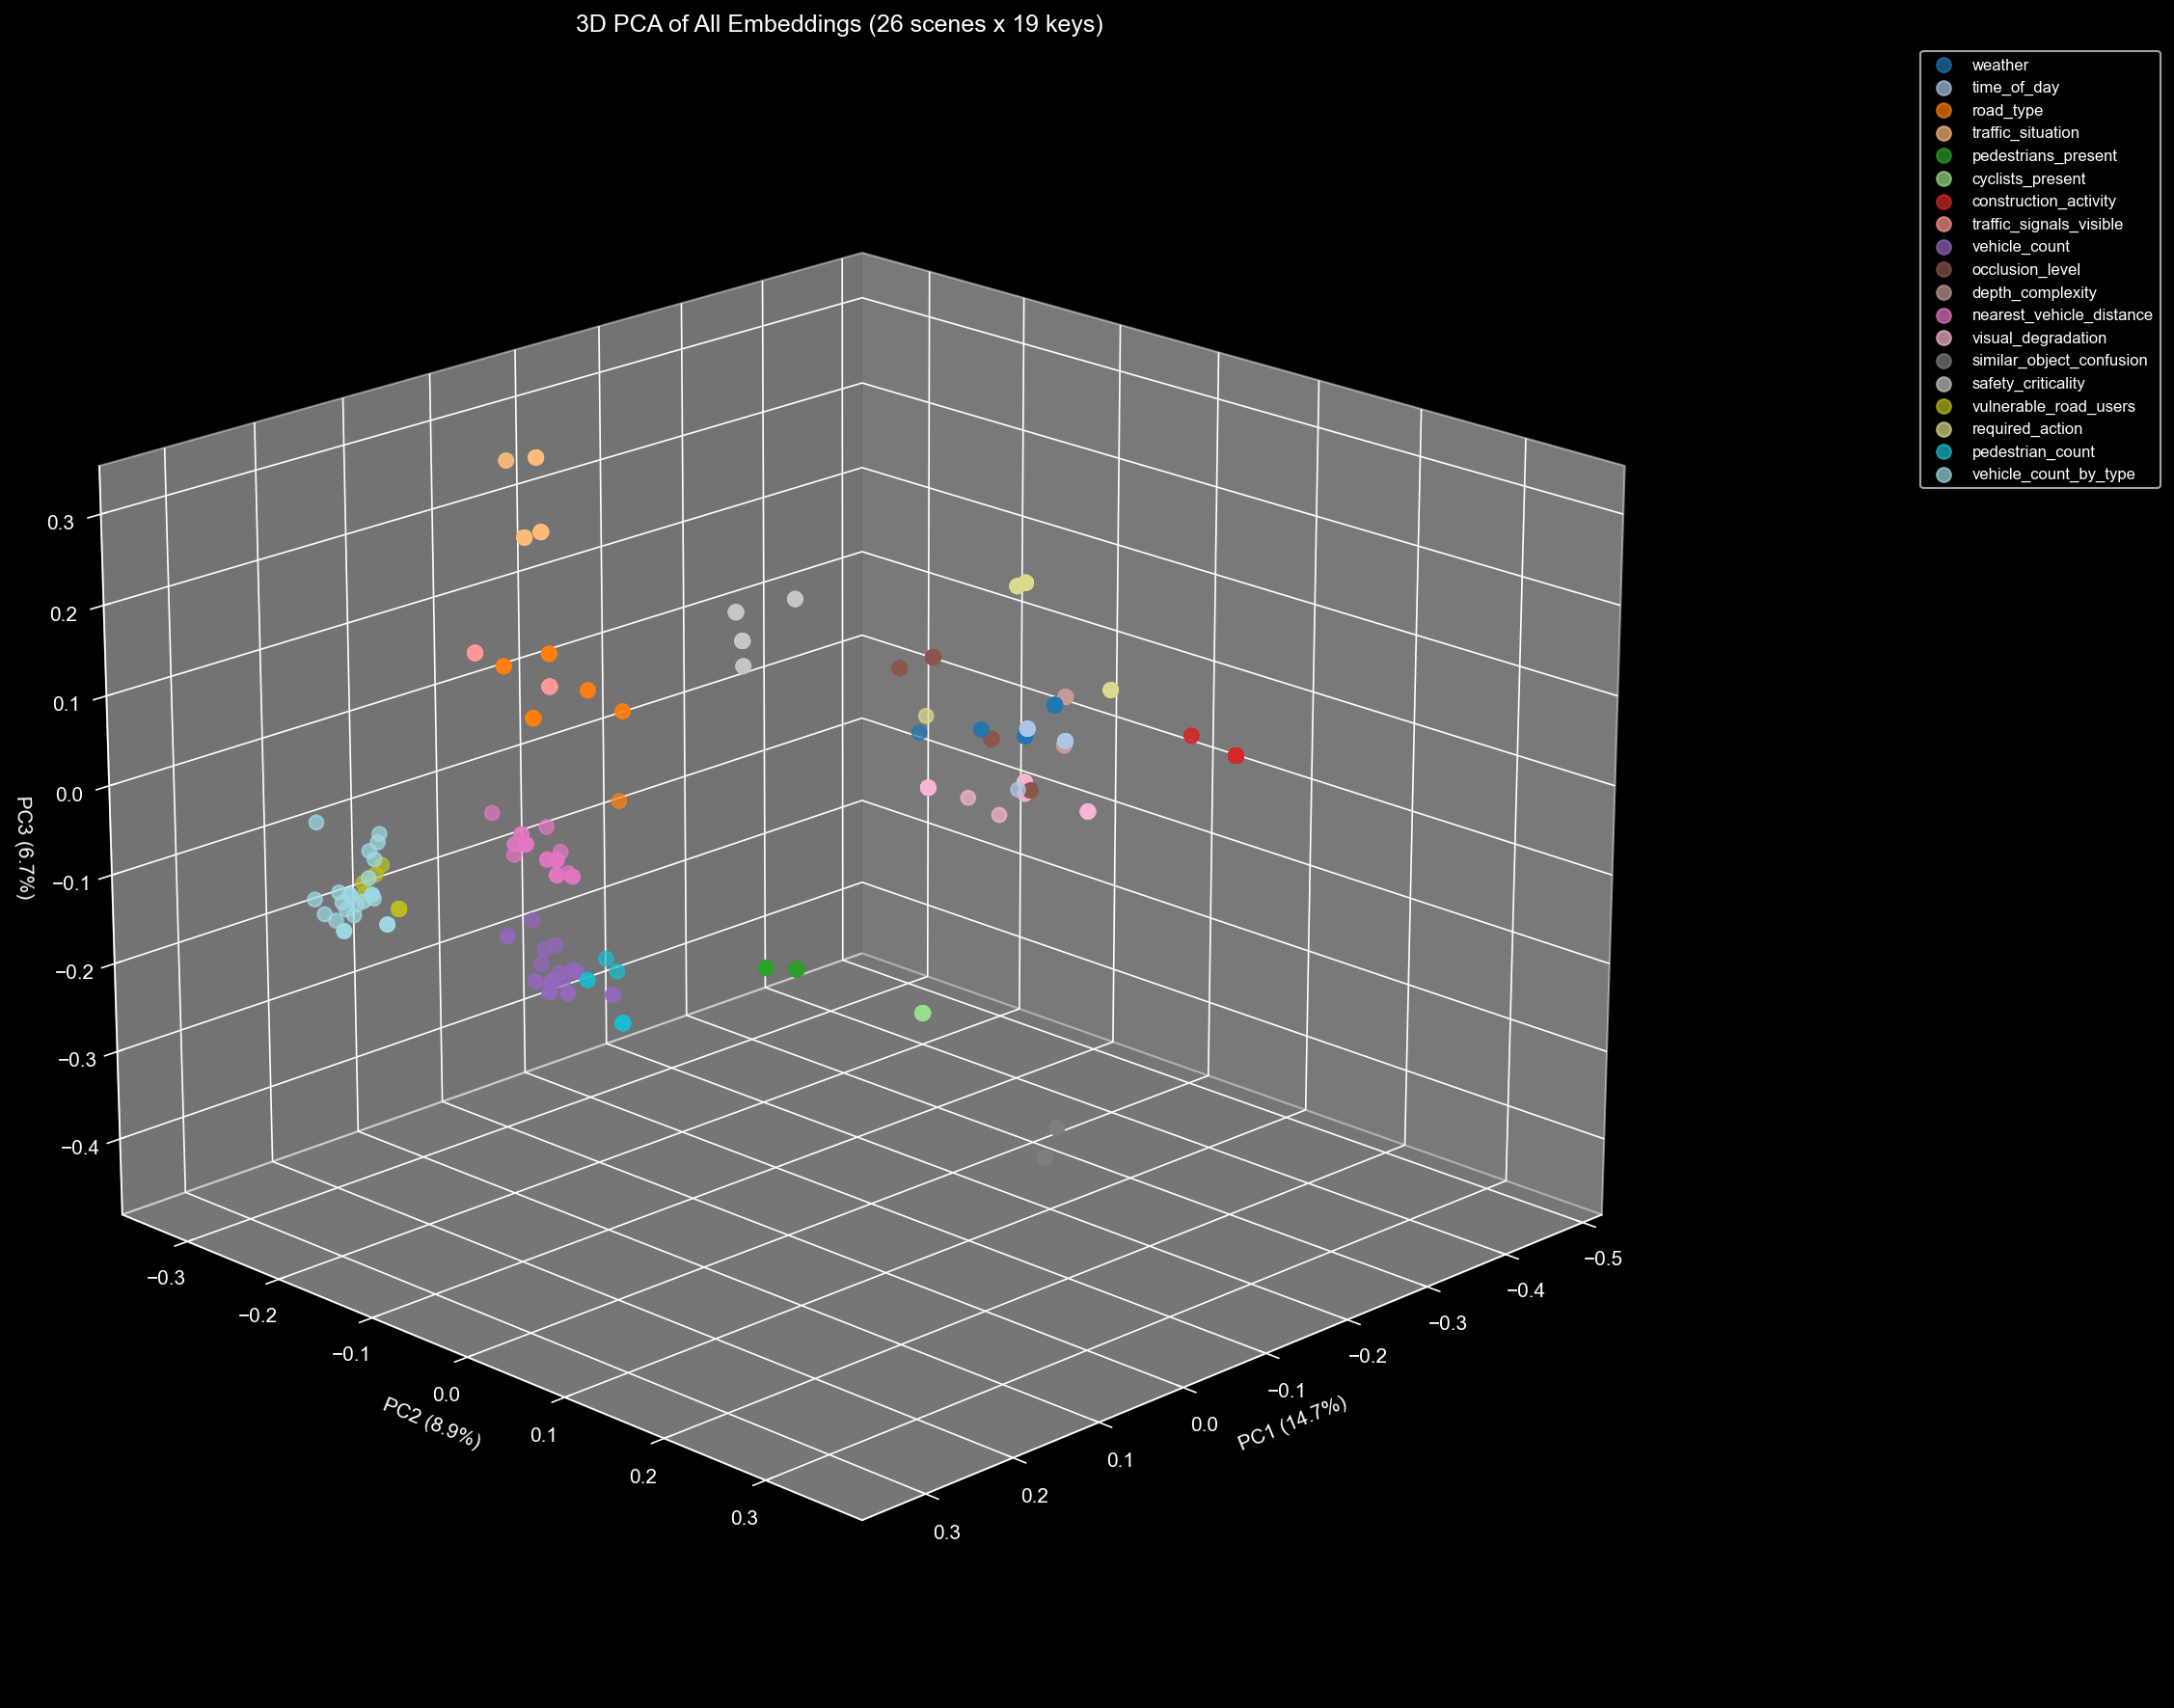

Saved: 01_pca_3d_by_key.png


In [34]:
# Create 3D PCA plot colored by key
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for key in unique_keys:
    mask = key_labels == key
    ax.scatter(pca_coords_3d[mask, 0], pca_coords_3d[mask, 1], pca_coords_3d[mask, 2],
               c=[key_to_color[key]], label=key, alpha=0.7, s=50)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax.set_title('3D PCA of All Embeddings (26 scenes x 19 keys)')
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=8)

# Set viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '01_pca_3d_by_key.png', bbox_inches='tight')
plt.show()

print(f'Saved: 01_pca_3d_by_key.png')